In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import pickle
from sklearn.metrics import mean_squared_error
import math

In [2]:
movies = pd.read_csv(r"C:\Users\Admin\PycharmProjects\machine-learning-group-16\data\movies_cleaned.csv")
ratings = pd.read_csv(r"C:\Users\Admin\PycharmProjects\machine-learning-group-16\data\ratings_cleaned.csv")

## 1. Data Preparation

In [3]:
# Merging the movies and ratings dataset
merged = pd.merge(movies, ratings, how = "inner", on = "movieId")

In [4]:
# Getting an average review for each movie
df = merged.groupby(by=["userId", "title"], as_index = False).agg({"rating": "mean"})
df["rating"] = df["rating"].values.astype(np.float32)

In [5]:
# Creating a new column that will be helpful for the model
df["user"] = df["userId"]-1

# Getting the unique number of users we have
n_users = df['user'].nunique()

In [6]:
# Creating a new column that will be helpful for the model
# It's the same as above but with the titles
final = df.sort_values("title", ascending = True)
final = final.drop_duplicates(subset=["title"])
final["movie"] = range(0, len(final))
final = final[["title", "movie"]]
df = pd.merge(df, final, on = ["title"])
n_movies = df["movie"].nunique()

In [7]:
# Sorting the values so that the dataframe is better organized
df = df.sort_values(by="userId")
df

userId                                title  rating    user  movie
0              1                2001: A Space Odyssey     3.5       0    163
836909         1  Highlander: Endgame (Highlander IV)     4.0       0  10354
313916         1                  Conan the Destroyer     3.0       0   4998
582083         1                        Exorcist, The     3.5       0   7510
313526         1               Company of Wolves, The     4.0       0   4979
...          ...                                  ...     ...     ...    ...
17916068  138493                            Manderlay     4.5  138492  14361
9204059   138493                  Lost in Translation     5.0  138492  13752
2008147   138493                         Spider-Man 2     4.0  138492  20857
9346162   138493                    National Treasure     3.0  138492  15845
2599020   138493                      American Beauty     5.0  138492   1079

[19928293 rows x 5 columns]

## 2. Model Testing

In [8]:
# Our independent variables will be "user" and "movie" that were defined previously
X = df[["user", "movie"]].values

# Our dependent variable will be "rating"
y = df["rating"].values

# Splitting the dataset into a training and test set, the training will constitute 80% of the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# The number of factors will be used whilst building the Neural Network
n_factors = 150

# Constructing the arrays with the values from above
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [10]:
# Normalizing the labels
y_train = (y_train - min(df['rating']))/(max(df['rating']) - min(df['rating']))
y_test = (y_test - min(df['rating']))/(max(df['rating']) - min(df['rating']))

#### 2.1 Building a Softmax Deep Neural Network

In [11]:
# Initializing an input layer for users
user = tf.keras.layers.Input(shape = (1,))

# Embedding layer using the total number of unique users as inputs
u = keras.layers.embeddings.Embedding(n_users, n_factors, embeddings_initializer = "he_normal", embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

In [12]:
# Initializing an input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

# Embedding layer using the total number of unique movies as inputs
m = keras.layers.embeddings.Embedding(n_movies, n_factors, embeddings_initializer = "he_normal", embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

In [13]:
# Stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
#x = tf.keras.layers.Dropout(0.05)(x)

In [14]:
# Adding the first Dense hidden layer with 32 neurons
x = tf.keras.layers.Dense(32, kernel_initializer = "he_normal")(x)
x = tf.keras.layers.Activation(activation = "relu")(x)
#x = tf.keras.layers.Dropout(0.05)(x)

# Adding a second Dense hidden layer with 16 neuros
x = tf.keras.layers.Dense(16, kernel_initializer = "he_normal")(x)
x = tf.keras.layers.Activation(activation = "relu")(x)
#x = tf.keras.layers.Dropout(0.05)(x)

In [15]:
# Adding an Output layer with softmax activation function (output between 0 and 1) with 10 neurons (one per class - 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5)
x = tf.keras.layers.Dense(10)(x)
x = tf.keras.layers.Activation(activation = "softmax")(x)

In [16]:
# Defining the model using the unique number of movies of user and movie as input
model = tf.keras.models.Model(inputs = [user, movie], outputs = x)

In [17]:
# Compiling the model
model.compile(optimizer = "sgd", loss="sparse_categorical_crossentropy", metrics = ["accuracy"])

**Justification:**
- *Optimizer* - Sgd means Stochastic Gradient Descent - This is a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data)
- *Loss* - Sparse categorical crossentropy - We are using sparse
- *Metrics* - It's useful to know the accuracy during training and evaluation

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 150)       20773950    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 150)       3857700     ['input_2[0][0]']                
                                                                                              

#### 2.2 Fitting and evaluation of the model

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=25000, epochs=100, verbose=1, validation_data=(X_test_array, y_test),shuffle=True,callbacks=[reduce_lr])

Epoch 1/100
638/638 [==============================] - 155s 240ms/step - loss: 0.6980 - accuracy: 0.0119 - val_loss: 0.4374 - val_accuracy: 0.0119 - lr: 0.0100
Epoch 2/100
638/638 [==============================] - 156s 244ms/step - loss: 0.4256 - accuracy: 0.0119 - val_loss: 0.4197 - val_accuracy: 0.0119 - lr: 0.0100
Epoch 3/100
638/638 [==============================] - 164s 257ms/step - loss: 0.4179 - accuracy: 0.0119 - val_loss: 0.4163 - val_accuracy: 0.0119 - lr: 0.0100
Epoch 4/100
638/638 [==============================] - 164s 257ms/step - loss: 0.4157 - accuracy: 0.0119 - val_loss: 0.4148 - val_accuracy: 0.0119 - lr: 0.0100
Epoch 5/100
638/638 [==============================] - 177s 278ms/step - loss: 0.4145 - accuracy: 0.0119 - val_loss: 0.4139 - val_accuracy: 0.0119 - lr: 0.0100
Epoch 6/100
638/638 [==============================] - 171s 267ms/step - loss: 0.4137 - accuracy: 0.0119 - val_loss: 0.4131 - val_accuracy: 0.0119 - lr: 0.0100
Epoch 7/100
638/638 [===================

In [40]:
# Saving the model
pickle.dump(model, open("dnn.pkl", "wb"))

INFO:tensorflow:Assets written to: ram://272e8822-9b8e-4654-8bdd-004784ea20d6/assets


['dnn_2.pkl']

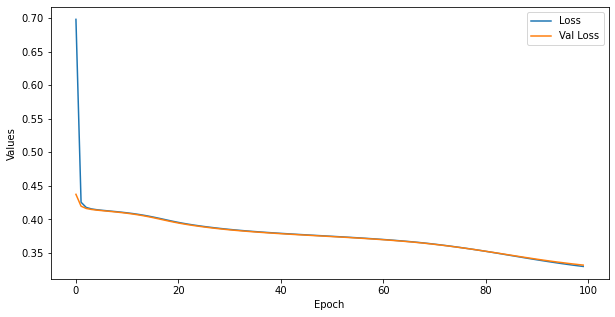

In [25]:
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Values")
plt.xlabel("Epoch")
plt.legend(["Loss", "Val Loss"], loc="upper right")
plt.show()

In [22]:
# Calculating the RMSE
user_test = [item[0] for item in X_test]
movies_test = [item[1] for item in X_test]
model_input = [np.asarray(user_test), np.asarray(movies_test)]
y_pred = model.predict(model_input)
y_pred = np.max(y_pred, axis = 1)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
RMSE

0.3579030784333847

## 3. Building the recommendation system

In [23]:
def neural_networks(user_id, model, n_movies):
    # Getting the encoded user
    encoded_user_id = [user_id-1]
    # Getting the encoded numbers of the movies that the user has seen
    seen_movies = list(df[df["userId"] == user_id]["movie"])
    # Getting the unseen movies (opposite of what is above)
    unseen_movies = []
    for value in final["movie"]:
        if value not in seen_movies:
            unseen_movies.append(value)
    # The model will receive a list with the user and its unseen movies
    model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
    # The model will then predict, based on these inputs, the ratings of the unseen movies
    # This will output arrays with 9 values (due to the density established above)
    predicted_ratings = model.predict(model_input)
    # Here we are picking the maximum rating of each array from the 9 values
    predicted_ratings = np.max(predicted_ratings, axis = 1)
    # Getting the top 10 ratings
    sorted_predicted_ratings = np.sort(predicted_ratings)[::-1][:n_movies]
    # Multiplying these ratings by 5 since the values from the sigmoid are only between 0 and 1 and we want between 0 and 5
    sorted_predicted_ratings = sorted_predicted_ratings*5
    # Gets the indices that would sort an array to then match with the df["movies"] that we already defined
    sorted_index = (-predicted_ratings).argsort()[:n_movies]
    # Extracts from the indexes, the names of the movies
    recommended_movies = []
    for value in sorted_index:
        recommended_movies.append(final.iloc[value]["title"])
    # Displays the recommended movies on a dataframe with the ratings on the side
    print("\nTop", n_movies, "Movie recommendations for the user", user_id, "are:")
    recommended_movies_df = pd.DataFrame()
    recommended_movies_df["titles"] = recommended_movies[:n_movies]
    recommended_movies_df["ratings"] = sorted_predicted_ratings
    return recommended_movies_df

In [24]:
user_id = int(input("Enter user id: "))
n_movies = int(input("Enter number of movies to be recommended: "))
neural_networks(user_id, model, n_movies)


Top 10 Movie recommendations for the user 1 are:


titles   ratings
0                                              Sonny  4.980223
1  White Light/Black Rain: The Destruction of Hir...  4.979362
2            Battle of Russia, The (Why We Fight, 5)  4.978295
3                        History of Future Folk, The  4.976980
4                                  An Amazing Couple  4.976084
5                                    Bat People, The  4.975940
6                                           Riffraff  4.974214
7                                   Hollywood Ending  4.974064
8                             Flame of Barbary Coast  4.973336
9                 Rififi (Du rififi chez les hommes)  4.972268